In [1]:
pygpstruct_location = '/home/sb358/pygpstruct-develop'
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
import numpy.random
sys.path.append(pygpstruct_location + '/src/') # replace by your path to .py files
np.set_printoptions(precision=3)


In [2]:
from hyperparameter_learning import *

/home/sb358/anaconda/envs/py3/lib/python3.4/site-packages/numba/tests/__init__.py:393: UserWarning: Failed to enable faulthandler due to:
IOStream has no fileno.
  warnings.warn(msg.format(err=e))


# study (sanity-check) ESS sampler

In [4]:
import ess_k_sampler
import util
util.read_randoms.prng = np.random.RandomState()

import kernels
import scipy

n_coordinates_f = 2
f = np.zeros((n_coordinates_f))
f = np.random.randn((n_coordinates_f))
normal_rv = scipy.stats.multivariate_normal(mean=np.array([0,1])) #np.ones((n_coordinates_f)))
logli =  lambda f : normal_rv.logpdf(f)

n_samples=1000
history_ll = np.empty((n_samples))
history_f = np.empty((n_samples, n_coordinates_f))

ll = logli(f)
for i in range(n_samples):
    if not np.mod(i,1000):
        print(' '.join(["%.2g " % v for v in f]))
        print(ll)
    history_f[i,:] = f
    history_ll[i] = ll
    (f, ll) = ess_k_sampler.ESS(f, logli, kernels.gram_compact(np.eye(1), 0, 1), util.read_randoms)

1.2  -1.6 
-6.03878150894


In [5]:
n_coordinates_f = 2
f = np.zeros((n_coordinates_f))
f = np.random.randn((n_coordinates_f))
normal_rv = scipy.stats.multivariate_normal(mean=np.array([0,1])) #np.ones((n_coordinates_f)))
logli =  lambda f : normal_rv.logpdf(f)

n_samples=1000
history_ll = np.empty((n_samples))
history_f = np.empty((n_samples, n_coordinates_f))

ll = logli(f)
for i in range(n_samples):
    if not np.mod(i,1000):
        print(' '.join(["%.2g " % v for v in f]))
        print(ll)
    history_f[i,:] = f
    history_ll[i] = ll
    (f, ll) = ess_k_sampler.ESS(f, logli, kernels.gram_compact(np.eye(1), 0, 1), util.read_randoms)

0.46  1.1 
-1.94505764549


In [123]:
n_labels=5
f = np.zeros((n_data * n_labels + n_labels ** 2))
n_data=5
ll_train = prepare_from_data_single_label(
            n_data=n_data,
            synthetic_data_type = '5-class',
            )[0] # retain only log-likelihood
(f, ll) = ess_k_sampler.ESS(f, ll_train, kernels.gram_compact(np.eye(n_data), 0, n_labels=5), util.read_randoms)
print(f)

[ 0.05   0.013  0.048  0.113  0.1    0.048  0.038 -0.136  0.013 -0.134
  0.022 -0.074  0.046  0.114  0.038  0.22  -0.098 -0.307 -0.136 -0.005
  0.051 -0.218  0.108  0.304 -0.036  0.    -0.     0.     0.    -0.    -0.
 -0.    -0.    -0.    -0.    -0.     0.    -0.     0.     0.     0.    -0.
 -0.     0.    -0.    -0.     0.     0.    -0.     0.   ]


# Geweke + KS test for Elliptical slice sampling#

In [6]:
# demonstrate that 1) can provide Y to ESS step, 2) changing Y changes sample f drawn from there
# NB wont work with 'single feature' - why ?

n_data = 10
n_samples = 10 # how many steps to run ESS for before picking the sample f
dataset = prepare_from_data_single_label(debug=True, synthetic_data_type='5-class', n_data=n_data)
print(dataset.Y[0])
(__, history_f, __, __) = learn_predict_gpstruct_wrapper(
            n_data = n_data,
            console_log=False, 
            synthetic_data_type=('predefined', dataset), # submits y sample as stored in dataset.Y
            n_samples=n_samples, 
            start_from_clean_slate=True # important cos y changes each time
            )
print(history_f[n_samples - 1][0]) # this is a sample from f

dataset.Y[0] = np.array([1])
print(dataset.Y[0])
(__, history_f, __, __) = learn_predict_gpstruct_wrapper(
            n_data = n_data,
            console_log=False, 
            synthetic_data_type=('predefined', dataset), # submits y sample as stored in dataset.Y
            n_samples=10, 
            start_from_clean_slate=True # important cos y changes each time
            )
print(history_f[n_samples - 1][0]) # this is a sample from f


# must manage to submit y to this procedure, instead of obtaning it from prepare_data

[0]
1.37336599827
[1]
-1.54711842537


In [83]:
# given f and dataset, must produce a sample from y (to be put into dataset.Y)
f = history_f[n_samples - 1]
posterior_marginals = prepare_from_data.posterior_marginals(f, dataset, marginals_function)
print(posterior_marginals)


[array([[ 0.059,  0.166,  0.632,  0.028,  0.115]]), array([[ 0.088,  0.337,  0.054,  0.072,  0.449]]), array([[ 0.054,  0.075,  0.689,  0.068,  0.114]]), array([[ 0.136,  0.198,  0.195,  0.448,  0.024]]), array([[ 0.067,  0.266,  0.088,  0.27 ,  0.309]]), array([[ 0.059,  0.163,  0.637,  0.028,  0.113]]), array([[ 0.088,  0.337,  0.055,  0.071,  0.449]]), array([[ 0.053,  0.076,  0.691,  0.067,  0.112]]), array([[ 0.138,  0.2  ,  0.188,  0.45 ,  0.024]]), array([[ 0.066,  0.269,  0.087,  0.268,  0.31 ]])]


In [84]:
import numpy.random
print(dataset.Y)

for n in range(n_data):
    p = posterior_marginals[n][0]
    dataset.Y[n] = np.array([numpy.random.choice(p.shape[0], p=p)]) # draw single categorical value distributed as given by p
print(dataset.Y)

[array([1]), array([1]), array([2]), array([3]), array([4]), array([0]), array([1]), array([2]), array([3]), array([4])]
[array([4]), array([4]), array([2]), array([0]), array([4]), array([2]), array([1]), array([2]), array([3]), array([0])]


## Putting everything together##

In [124]:
def forward_sampling_y_given_f(f, dataset):
    posterior_marginals = prepare_from_data.posterior_marginals(f, dataset, marginals_function)
    for n in range(n_data):
        p = posterior_marginals[n][0]
        dataset.Y[n] = np.array([numpy.random.choice(p.shape[0], p=p)]) # draw single categorical value distributed as given by p
    # as side-effect, dataset.Y has been modified

n_labels=5
n_data=5
def transition_operator_f_given_y(f, dataset, 
                                  kernel_gram = kernels.gram_compact(np.eye(n_data), 0, n_labels) # note default kernel has zero binaries
                                  ):
    """ single step of ESS MCMC transition operator, takes old f, returns new f """ 
    ll_train = prepare_from_data_single_label(
                n_data=n_data,
                synthetic_data_type = ('predefined', dataset),
                )[0] # retain only log-likelihood
    (f, ll) = ess_k_sampler.ESS(f, ll_train, kernel_gram, util.read_randoms)
    return f

# below not used in Geweke test 
"""
def backward_sampling(dataset, random_seed=0): 
    n_samples = 10 # how many steps to run ESS for before picking the sample f
    (__, history_f, __, __) = learn_predict_gpstruct_wrapper(
                n_data = dataset.N,
                console_log=False, 
                synthetic_data_type=('predefined', dataset), # submits y sample as stored in dataset.Y
                n_samples=n_samples, 
                start_from_clean_slate=True, # important cos y changes each time
                random_seed=random_seed,
                )
    return history_f[n_samples - 1] # this is a sample from f
"""

# should work equally fine when initializing f randomly, or initializing y to some constructed values

In [3]:
# plotting function, will plot distribution histogram and CDF plot side-by-side
import matplotlib.pyplot as plt
%matplotlib inline

def plot(fs, 
         title='',
         prior=scipy.stats.norm(loc=0, scale=1)):
    fig, axarr = plt.subplots(1,2, figsize=(20,6))
    #axarr[0].set_xlim([-0.1,0.1])
    n = fs.shape[0]
    linspace = np.linspace(start=-10, stop=10, num=n)
    axarr[0].plot(linspace,  prior.pdf(linspace), label='prior distribution')
    axarr[0].hist(fs, bins=30,normed=1, label='empirical posterior distribution')
    axarr[0].set_ylabel('Normalized frequency/ density')
    axarr[0].set_xlabel('x')
    axarr[0].legend()
    axarr[0].set_title(title)

    axarr[1].plot(linspace, prior.cdf(linspace), label='prior distribution')
    axarr[1].plot(np.sort(fs, axis=0), np.arange(n)/n, label='empirical posterior distribution')
    axarr[1].set_ylabel('CDF')
    axarr[1].set_xlabel('x')
    axarr[1].legend()

NameError: name 'scipy' is not defined

[ 1.005  0.976  1.005  0.968  1.031  0.955  0.998  0.992  0.994  0.964
  1.049  0.931  0.96   0.987  0.94   1.028  0.965  0.952  0.975  1.034
  1.044  1.018  1.012  1.038  0.969  0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.   ]
[ 0.179 -0.055 -0.042 -0.052  0.01  -0.023  0.012  0.049  0.018  0.083
  0.02  -0.058 -0.012 -0.06   0.012  0.022 -0.046 -0.122  0.015  0.03
 -0.091 -0.101 -0.008 -0.044 -0.035  0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.   ]


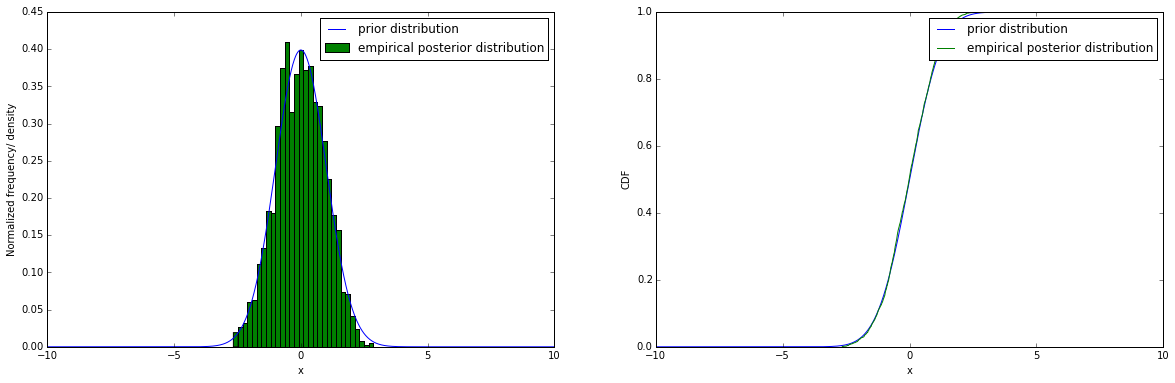

In [134]:
# example run: looking at element f[5] only; 5-class data, no noise features
n_data = 5 # data points used in training set
dataset = prepare_from_data_single_label(debug=True, synthetic_data_type='5-class', n_data=n_data)
n_steps = 2000 # steps of Geweke 
fs = np.zeros((n_steps + 1, np.max(dataset.binaries) + 1)) # will receive the history of f's
for i in range(n_steps):
    fs[i + 1, :] = transition_operator_f_given_y(fs[i,:], dataset)
    forward_sampling(fs[i+1,:], dataset)
fs = fs[1:,:]
#print(fs)
print(np.std(fs, axis=0))
print(np.mean(fs, axis=0))

## apply KS test to all unary elements of f, to check they obey their prior

In [135]:
# effective sample size function
def ess_biopy(data, stepSize = 1) :
  """ Effective sample size, as computed by BEAST Tracer."""
  samples = len(data)

  assert len(data) > 1,"no stats for short sequences"
  
  maxLag = min(samples//3, 1000)

  gammaStat = [0,]*maxLag
  #varGammaStat = [0,]*maxLag

  varStat = 0.0;

  if type(data) != np.ndarray :
    data = np.array(data)

  normalizedData = data - data.mean()
  
  for lag in range(maxLag) :
    v1 = normalizedData[:samples-lag]
    v2 = normalizedData[lag:]
    v = v1 * v2
    gammaStat[lag] = sum(v) / len(v)
    #varGammaStat[lag] = sum(v*v) / len(v)
    #varGammaStat[lag] -= gammaStat[0] ** 2

    # print lag, gammaStat[lag], varGammaStat[lag]
    
    if lag == 0 :
      varStat = gammaStat[0]
    elif lag % 2 == 0 :
      s = gammaStat[lag-1] + gammaStat[lag]
      if s > 0 :
         varStat += 2.0*s
      else :
        break
      
  # standard error of mean
  # stdErrorOfMean = Math.sqrt(varStat/samples);

  # auto correlation time
  act = stepSize * varStat / gammaStat[0]

  # effective sample size
  ess = (stepSize * samples) / act

  return ess

(2000, 50)


(array([ 1.,  0.,  3.,  2.,  2.,  6.,  1.,  3.,  3.,  3.]),
 array([ 216.685,  235.075,  253.465,  271.854,  290.244,  308.634,
         327.024,  345.414,  363.804,  382.194,  400.584]),
 <a list of 10 Patch objects>)

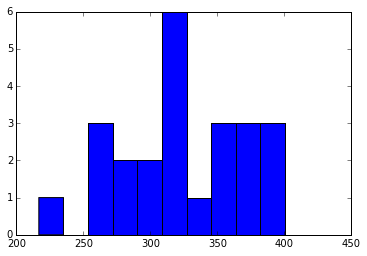

In [144]:
# start by looking at effective sample size for each element of f separately, to get a feeling
n_f_index_max = np.max(dataset.unaries)
ess_f = np.array([ess_biopy(fs[:,i]) for  i in range(n_f_index_max)])

print(fs.shape)
plt.hist(ess_f)

In [160]:
# decide to thin so as to obtain at most 250 samples, to make them as independent as possible
n_f_index_max = np.max(dataset.unaries)
ess_f = np.zeros((n_f_index_max))
ess_min = 250 # estimated off histogram, conservative (ie fewer samples remain, more independent, so KS test more likely to work)
thinning_rate = fs.shape[0] // ess_min

# KS test on every unary element of f (binaries are all zero because of kernel chosen)
for i in range(n_f_index_max):
    D, p = scipy.stats.kstest(rvs=fs[::thinning_rate, i], cdf=lambda x : scipy.stats.norm(loc=0, scale=1).cdf(x=x))
    print("KS statistic D = %.3f, p-value = %.2f (to be compared to 0.05), H_0 = from same distribution -- " % (D,p), end='')
    if p < 0.05:
        print("reject H_0")
    else:
        print("fail to reject H_0")


KS statistic D = 0.082, p-value = 0.06 (to be compared to 0.05), H_0 = from same distribution -- fail to reject H_0
KS statistic D = 0.048, p-value = 0.62 (to be compared to 0.05), H_0 = from same distribution -- fail to reject H_0
KS statistic D = 0.041, p-value = 0.78 (to be compared to 0.05), H_0 = from same distribution -- fail to reject H_0
KS statistic D = 0.034, p-value = 0.94 (to be compared to 0.05), H_0 = from same distribution -- fail to reject H_0
KS statistic D = 0.044, p-value = 0.73 (to be compared to 0.05), H_0 = from same distribution -- fail to reject H_0
KS statistic D = 0.062, p-value = 0.28 (to be compared to 0.05), H_0 = from same distribution -- fail to reject H_0
KS statistic D = 0.039, p-value = 0.84 (to be compared to 0.05), H_0 = from same distribution -- fail to reject H_0
KS statistic D = 0.045, p-value = 0.70 (to be compared to 0.05), H_0 = from same distribution -- fail to reject H_0
KS statistic D = 0.056, p-value = 0.40 (to be compared to 0.05), H_0 = f

## results for different random seeds

In [170]:
n_data = 5
dataset = prepare_from_data_single_label(debug=True, synthetic_data_type='5-class', n_data=n_data)
n_steps = 2000
n_ks_test = 0
n_ks_test_reject_H0 = 0

for random_seed in range(5):
    fs = np.zeros((n_steps + 1, np.max(dataset.binaries) + 1)) # will receive the history of f's
    for i in range(n_steps):
        fs[i + 1, :] = transition_operator_f_given_y(fs[i,:], dataset)
        forward_sampling(fs[i+1,:], dataset)
    fs = fs[1:,:]
    
    # now run KS test for each element of f
    for i in range(np.max(dataset.unaries)):
        thinning_rate = fs.shape[0]//ess_biopy(fs[:,i])
        D, p = scipy.stats.kstest(rvs=fs[::thinning_rate, i], cdf=lambda x : scipy.stats.norm(loc=0, scale=1).cdf(x=x))
        n_ks_test += 1
        if p < 0.05:
            n_ks_test_reject_H0 += 1
        else:
            pass
print("rejected %.2f of %g KS tests" % (n_ks_test_reject_H0/ n_ks_test, n_ks_test))

rejected 0.050% of 120 KS tests


This ran 2000 Geweke steps, using the transition operator implemented in my ESS code, the 5-class data (classification problem with indicator features, n_data = 5), a kernel consisting of identity for unary latent variables, and zero for binary latent variables. The $\mathbb{f}$ values resulting from the Geweke procedures are thinned to obtain a number of (independent) data points approximately equal to the effective sample size (around 250 for 2000 points). The resulting f samples are compared to their prior distribution through the KS test, at a significance threshold of $\alpha = 0.05$. The test shows that all the values of f (except 5%) statistically seem to come from the prior distribution. I take this to confirm that the ESS MCMC procedure has been correctly implemented.